[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)


# 流式传输

## 回顾

在模块 2 中，我们讲了几种自定义图状态和记忆的方法。
 
我们构建了一个带外部记忆的聊天机器人，可以维持长时间的对话。

## 目标

本模块将深入探讨 `human-in-the-loop`，它建立在记忆之上，让用户能够以多种方式直接与图互动。

为了给 `human-in-the-loop` 奠定基础，我们先看看流式传输，这提供了多种在执行过程中可视化图输出（例如节点状态或聊天模型 token）的方法。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## 流式传输

LangGraph 天生具备[一流的流式传输支持](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming)。

让我们设置模块 2 中的聊天机器人，并展示在图执行期间以不同方式流式传输输出。


In [ ]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

注意我们用 `call_model` 配合 `RunnableConfig` 来启用按 token 的流式传输。[只有在 Python < 3.11 时才需要这样做](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/)。我们也把它保留下来，以防你在 Colab 中运行本 notebook（Colab 使用 Python 3.x）。


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


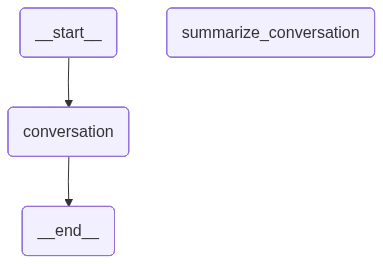

In [ ]:
from IPython.display import Image, display

# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
# model = ChatOpenAI(model="gpt-4o", temperature=0)
model = ChatTongyi(model="qwen-plus", temperature=0)


# State
class State(MessagesState):
    summary: str


# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}


def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


# Determine whether to end or summarize the conversation
def should_continue(state: State):
    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END


# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### 流式传输完整状态

现在，让我们讨论如何[流式传输图状态](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming)。

`.stream` 和 `.astream` 分别是同步与异步方法，用于流式返回结果。
 
LangGraph 为[图状态](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)提供了几种[不同的流式模式](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)：
 
* `values`：在每个节点执行后流式传回图的完整状态。
* `updates`：在每个节点执行后仅流式传回对图状态的更新。

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

来看看 `stream_mode="updates"`。

因为我们使用 `updates` 进行流式传输，所以只能看到每个节点运行后对状态的更新。

每个 `chunk` 是一个字典，键是 `node_name`，值是更新后的状态。


In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream(
    {"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"
):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hello, Lance! ٩(◕‿◕｡)۶ How's your day going? I'd love to hear what's on your mind or help with anything you need!", additional_kwargs={}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': 'cfedf183-e22b-4c0a-803f-afac4b16d791', 'token_usage': {'input_tokens': 13, 'output_tokens': 38, 'total_tokens': 51, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--be65ae1a-0056-4aa2-ad04-23092f41172e-0')}}


接下来我们只打印状态更新。


In [ ]:
# Start conversation
for chunk in graph.stream(
    {"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"
):
    chunk["conversation"]["messages"].pretty_print()

================================== Ai Message ==================================

Hi again, Lance! ٩(◕‿◕｡)۶ I remember you—welcome back! Is there something fun or interesting you'd like to chat about? Or maybe a question I can help with? 😊


现在看看 `stream_mode="values"`。

这是 `conversation` 节点运行后图的`完整状态`。


In [ ]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("---" * 25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! ٩(◕‿◕｡)۶ How's your day going? I'd love to hear what's on your mind or help with anything you need!
---------------------------------------------------------------------------


### 流式传输 token

我们通常希望流式传输的不仅仅是图状态。

特别是调用聊天模型时，常见需求是实时流式传回生成的 token。

我们可以使用[`.astream_events` 方法](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node)来实现，它会按事件发生的顺序从节点中流式传回事件！

每个事件都是一个包含多个键的字典：
 
* `event`：事件的类型。
* `name`：事件名称。
* `data`：与事件相关的数据。
* `metadata`：包含 `langgraph_node`，即发出事件的节点。

来看一下。


In [ ]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events(
    {"messages": [input_message]}, config, version="v2"
):
    print(
        f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}"
    )

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. Name: ChatTongyi
Node: conversation. Type: on_chat_model_stream. N

关键在于，图中的聊天模型所产生的 token 事件类型为 `on_chat_model_stream`。

我们可以用 `event['metadata']['langgraph_node']` 来筛选想要流式传输的节点。

我们还可以用 `event['data']` 获取每个事件的实际数据，在这个例子中是 `AIMessageChunk`。


In [ ]:
node_to_stream = "conversation"
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events(
    {"messages": [input_message]}, config, version="v2"
):
    # Get chat model tokens from a particular node
    if (
        event["event"] == "on_chat_model_stream"
        and event["metadata"].get("langgraph_node", "") == node_to_stream
    ):
        print(event["data"])

{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--c3f7ff0f-0444-4900-b133-ff189a45961b')}
{'chunk': AIMessageChunk(content=' **', additional_kwargs={}, response_metadata={}, id='run--c3f7ff0f-0444-4900-b133-ff189a45961b')}
{'chunk': AIMessageChunk(content='San Francisco ', additional_kwargs={}, response_metadata={}, id='run--c3f7ff0f-0444-4900-b133-ff189a45961b')}
{'chunk': AIMessageChunk(content='49ers', additional_kwargs={}, response_metadata={}, id='run--c3f7ff0f-0444-4900-b133-ff189a45961b')}
{'chunk': AIMessageChunk(content='** are a professional American', additional_kwargs={}, response_metadata={}, id='run--c3f7ff0f-0444-4900-b133-ff189a45961b')}
{'chunk': AIMessageChunk(content=' football team based in the San', additional_kwargs={}, response_metadata={}, id='run--c3f7ff0f-0444-4900-b133-ff189a45961b')}
{'chunk': AIMessageChunk(content=' Francisco Bay Area.', additional_kwargs={}, response_metadata={}, id='run--c3f7ff0f-0444-4900-b133-

如上所示，只要使用 `chunk` 键就能拿到 `AIMessageChunk`。


In [9]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events(
    {"messages": [input_message]}, config, version="v2"
):
    # Get chat model tokens from a particular node
    if (
        event["event"] == "on_chat_model_stream"
        and event["metadata"].get("langgraph_node", "") == node_to_stream
    ):
        data = event["data"]
        print(data["chunk"].content, end="|")

The| **|San Francisco |49ers|** are a professional American| football team based in the San| Francisco Bay Area.| They compete in the National| Football League (NFL) as| a member of the| **National Football Conference (|NFC) West division|**. The team| plays its home games| at **Levi|'s Stadium** in| Santa Clara, California,| which opened in 2|014.

|### History and Origins|
- **Founded**: |1946| (as a charter| member of the All|-America Football Conference|, or AAFC)
-| **Joined NFL**: |1950|, after the AA|FC merged with the NFL|
- **Name Origin|**: The name "49|ers" refers to the **|California Gold Rush of| 184|9**, when thousands| of prospectors f|locked to northern California in| search of gold.

### Championships| and Success
The| 49ers are one| of the most successful teams| in NFL history:
|- **Super Bowl Wins|**: 5 championships| (tied for| second-most all-time| with the Cowboys and Packers|; behind only the Steelers with| 6)
 | - **Super Bowl XVI|** (19|81 season):| Defeated th

### 搭配 LangGraph API 的流式传输

**⚠️ 免责声明**

自从录制这些视频以来，我们已经更新了 Studio，使其可以在本地运行并在浏览器中打开。现在推荐的方式是以这种形式运行 Studio（而不是像视频中展示的桌面应用）。关于本地开发服务器请查看[这里](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)的文档，关于本地 Studio 的运行方式请查看[这里](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。在本模块的 `/studio` 目录中，在终端运行以下命令即可启动本地开发服务器：

```
langgraph dev
```

你应该会看到如下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

在浏览器中访问 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

LangGraph API [支持编辑图状态](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation)。


In [ ]:
if "google.colab" in str(get_ipython()):
    raise Exception(
        "Unfortunately LangGraph Studio is currently not supported on Google Colab"
    )

In [11]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

像之前那样，让我们[流式传输 `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/)。


In [12]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="values",
):
    print(event)

StreamPart(event='metadata', data={'run_id': '01998616-d7bb-7464-908d-f54e7562fb9d', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '5e0d71cb-2425-42d2-a1f2-816611ed074c', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '5e0d71cb-2425-42d2-a1f2-816611ed074c', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_4899a42be33b40c7b6a8f8', 'type': 'function', 'function': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}}]}, 'response_metadata': {'model_name': 'qwen-plus', 'finish_reason': 'tool_calls', 'request_id': 'a0c4f37f-7ed7-41a4-83e0-2ff894103aac', 'token_usage': {'input_tokens': 350, 'output_tokens': 24, 'total_tokens': 374, 'prompt_tokens_details': {'cached_tokens': 0

流式传回的对象包含： 

* `event`：事件类型
* `data`：状态


In [13]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="values",
):
    messages = event.data.get("messages", None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print("=" * 25)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='75e72bd9-dbc2-4a49-a46f-8b6c4549181d'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': None, 'tool_calls': [{'index': 0, 'id': 'call_9838b3bb857f4947bb33c0', 'type': 'function', 'function': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}}]} response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'tool_calls', 'request_id': '05803dbc-843b-409a-973b-e9054b45525f', 'token_usage': {'input_tokens': 350, 'output_tokens': 24, 'total_tokens': 374, 'prompt_tokens_details': {'cached_tokens': 0}}} id='run--b3c745ec-b07c-4d9b-9360-c452149b0690-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_9838b3bb857f4947bb33c0', 'type': 'tool_call'}]
content='6' name='multiply' id='3923a49c-098c-4752-9016-f1a163de25a0' tool_call_id='call_9838b3bb857f4947bb33c0'
content='The result of multiplying 2 and 3 is 6.' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': None

API 还支持一些新的流式模式。

例如，我们可以使用[`messages` 模式](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/)来更好地处理上述场景！

这种模式目前假设你的图里有一个 `messages` 键，并且它是消息列表。

使用 `messages` 模式发出的所有事件都有两个属性：

* `event`：事件名称
* `data`：与事件相关的数据


In [14]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",
):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


我们可以看到几个事件： 

* `metadata`：有关运行的元数据
* `messages/complete`：完整成形的消息 
* `messages/partial`：聊天模型的 token

你可以在[这里](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages)进一步了解这些事件的类型。

现在我们来展示如何流式传输这些消息。 

我们会定义一个辅助函数，以便更好地格式化消息中的工具调用。


In [15]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")


def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"


async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",
):

    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)

    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print("-" * 50)

Metadata: Run ID - 01998687-ebed-77be-966d-56bda4002857
--------------------------------------------------
Tool Calls:
Tool Call ID: call_93788bfc8f0b4555a9adc8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_93788bfc8f0b4555a9adc8call_93788bfc8f0b4555a9adc8, Function: multiply, Arguments: {'a': 2, 'b': 3}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_93788bfc8f0b4555a9adc8call_93788bfc8f0b4555a9adc8call_93788bfc8f0b4555a9adc8, Function: multiply, Arguments: {'a': 2, 'b': 3}
Response Metadata: Finish Reason - tool_calls
--------------------------------------------------
AI: The
--------------------------------------------------
AI: The result
--------------------------------------------------
AI: The result of multiplying 
--------------------------------------------------
AI: The result of multiplying 2 and 
--------------------------------------------------
AI: The result of